In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter  

from sklearn.tree import DecisionTreeClassifier

In [3]:
datos = pd.read_csv('/home/juan/proyectoTesis/datasets/creditcard.csv')

print(datos.shape)

#Ver balanceo de la clase objetivo. Diabetes_012
porcentaje = 100*datos['Class'].value_counts()/len(datos)
print(porcentaje.astype(str) + '%')

(284807, 31)
Class
0       99.827251436938%
1    0.1727485630620034%
Name: count, dtype: object


In [3]:
#Funciones run_model() y evaluate_model()


def run_model(X_train, X_test, Y_train, Y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, Y_train)
    return clf_base
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [4]:
X = datos.drop('Class', axis=1)
y= datos['Class'] 

X_train, X_test,y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)



In [5]:
model_lr_desbalanceado = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")

model_lr_desbalanceado.fit(X_train, y_train)



LogisticRegression(random_state=1, solver='newton-cg')

           train  test
Exactitud   1.00  1.00
F1          0.75  0.70
APS         0.77  0.76
ROC AUC     0.98  0.97


(           train  test
 Exactitud   1.00  1.00
 F1          0.75  0.70
 APS         0.77  0.76
 ROC AUC     0.98  0.97,
 <Figure size 2000x600 with 3 Axes>)

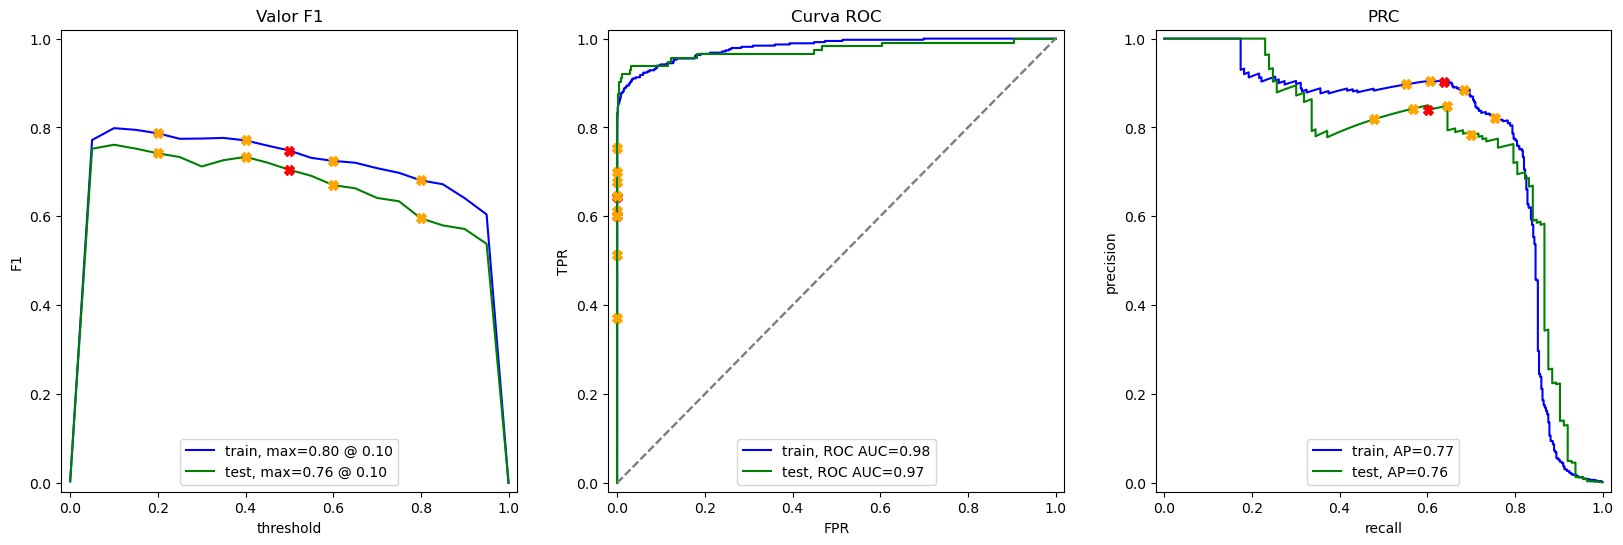

In [6]:
evaluate_model(model_lr_desbalanceado, X_train, y_train, X_test, y_test)

Text(0.5, 1.0, 'Confusion matrix')

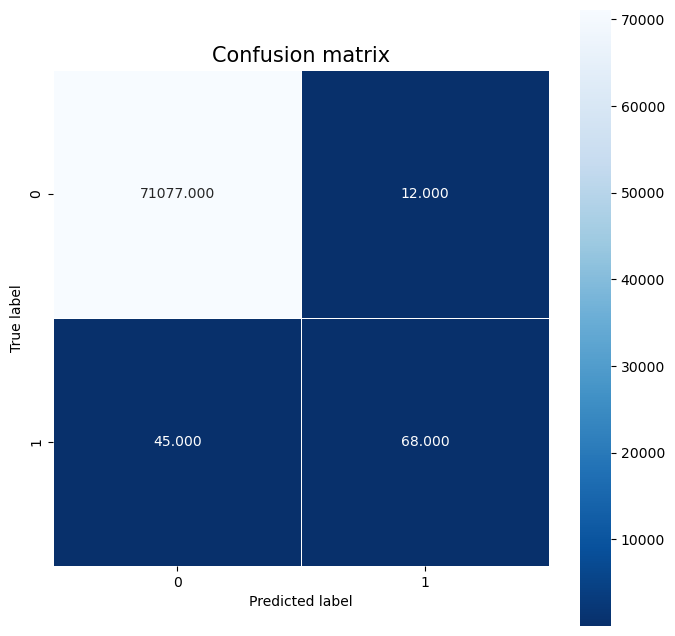

In [7]:
y_pred_desbalanced= model_lr_desbalanceado.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_desbalanced)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix', size = 15)

In [8]:
print(f'Metricas del dataset desbalanceado')
print(f'Precision: {precision_score(y_test, y_pred_desbalanced)}')
print(f'Recall: {recall_score(y_test, y_pred_desbalanced)}')
print(f'F1: {f1_score(y_test, y_pred_desbalanced)}')

Metricas del dataset desbalanceado
Precision: 0.85
Recall: 0.6017699115044248
F1: 0.7046632124352331


In [13]:
#SMOTE resampleo de la clase minoritaria sin duplicados
os_us = SMOTE(sampling_strategy=0.75)
X_train_smote, y_train_smote = os_us.fit_resample(X_train, y_train)

print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_smote)))

before resampling Counter({0: 213226, 1: 379})
after resampling Counter({0: 213226, 1: 159919})


In [14]:
model_lr_balanceado_smote = LogisticRegression(C=1.0,penalty='l2',random_state=42,solver="newton-cg")
model_lr_balanceado_smote.fit(X_train_smote, y_train_smote)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/optimize.py:319: ConvergenceWarning: newton-cg failed to converge at loss = 0.0622796132050987. Increase the number of iterations.
  warnings.warn(


LogisticRegression(random_state=42, solver='newton-cg')

           train  test
Exactitud   0.98  0.99
F1          0.98  0.30
APS         1.00  0.73
ROC AUC     1.00  0.98


(           train  test
 Exactitud   0.98  0.99
 F1          0.98  0.30
 APS         1.00  0.73
 ROC AUC     1.00  0.98,
 <Figure size 2000x600 with 3 Axes>)

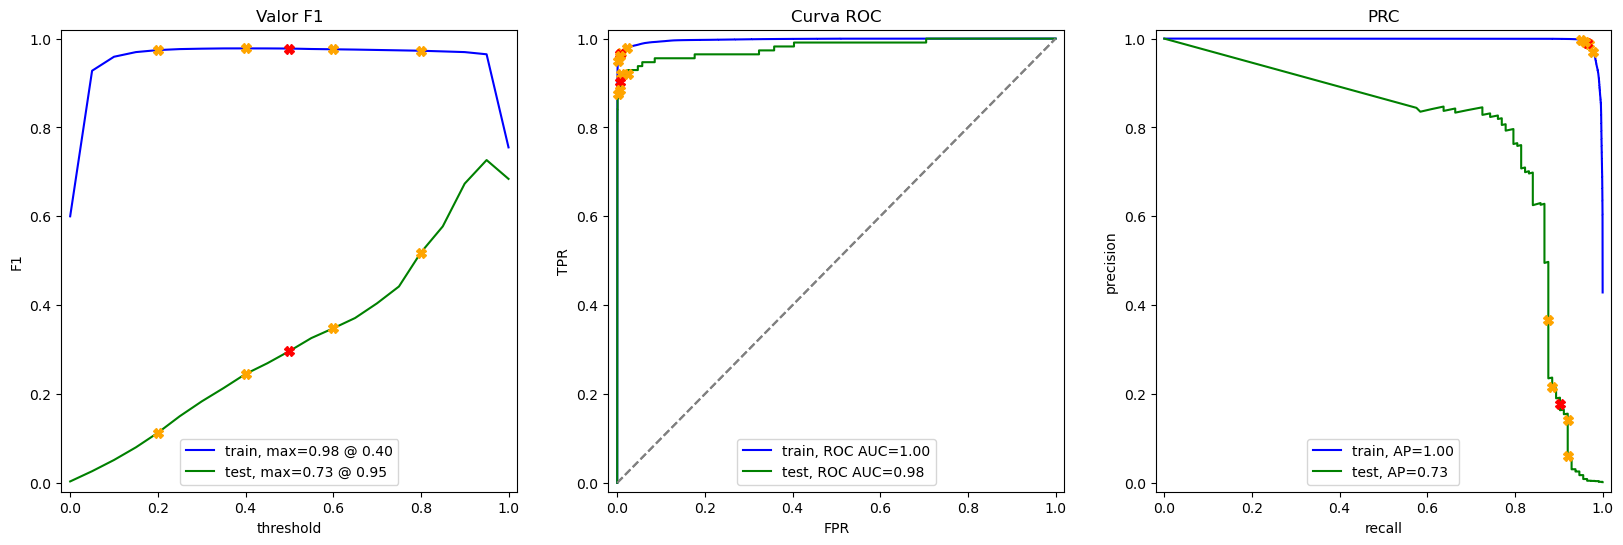

In [15]:
evaluate_model(model_lr_balanceado_smote, X_train_smote, y_train_smote, X_test, y_test)

In [16]:
y_pred_semibalanced = model_lr_balanceado_smote.predict(X_test)

print(f'Metricas del dataset semibalanceado')
print(f'Precision: {precision_score(y_test, y_pred_semibalanced)}')
print(f'Recall: {recall_score(y_test, y_pred_semibalanced)}')
print(f'F1: {f1_score(y_test, y_pred_semibalanced)}')

Metricas del dataset semibalanceado
Precision: 0.17739130434782607
Recall: 0.9026548672566371
F1: 0.29651162790697677


In [19]:
def tasa_inconsistencia(df, subconjunto_caracteristicas, clase):

    m = len(df)
    total_inconsistencias = 0
    grupos = df.groupby(subconjunto_caracteristicas)
    for nombre_grupo, df_grupo in grupos:
        #numero total de instancias en cada grupo
        n = len(df_grupo)

        conteo_clases = df_grupo[clase].value_counts()
        # numero de instancias del grupo pertenecientes a la clase mas frecuente.
        if len(conteo_clases)>1:
            max_clase = conteo_clases.max()
            inconsistencias_grupo = n - max_clase
            total_inconsistencias+= inconsistencias_grupo

    return total_inconsistencias/m



In [21]:
df_train_completo

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,59741.000000,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,38.420000,0
1,45648.000000,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,61.200000,0
2,31579.000000,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,110.950000,0
3,80455.000000,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,10.000000,0
4,39302.000000,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,22.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373140,125653.190817,0.398507,2.793621,-3.249036,4.006043,3.473280,0.147341,0.976108,-0.579426,-2.255500,...,0.461268,-0.804608,-0.381685,-0.903535,0.665853,0.269768,0.257341,0.379037,0.336643,1
373141,55974.389728,-2.975482,-0.196779,-0.542482,2.401171,0.034766,-0.880455,-1.545820,-1.356661,-0.426663,...,1.169149,-0.186880,-0.243141,0.373716,-0.202634,-0.331085,1.005897,0.009629,222.481575,1
373142,8196.130398,0.554164,4.187442,-7.253873,7.189680,0.999591,-2.765313,-1.521119,0.545086,-2.515240,...,0.402340,0.082758,0.129627,-0.239757,-0.765175,0.423124,0.649705,0.196265,1.000000,1
373143,56569.518467,-8.652227,2.760423,-7.674190,6.850341,-5.046127,-0.469087,-9.615520,1.647399,-4.437020,...,-0.097110,0.363718,0.004592,-0.422289,0.178446,0.291644,0.067001,-0.114751,7.000288,1


In [23]:
df_train_completo = pd.concat([X_train_smote, y_train_smote], axis=1)

tasa_inconsistencia(df_train_completo, ["V1"], "Class")

0.0